<a href="https://colab.research.google.com/github/jaalvalcan/GEE_index_sets/blob/main/NDVI_Montly_Standalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import ee

In [5]:

ee.Authenticate()
ee.Initialize(project='ee-jaalvalcan')



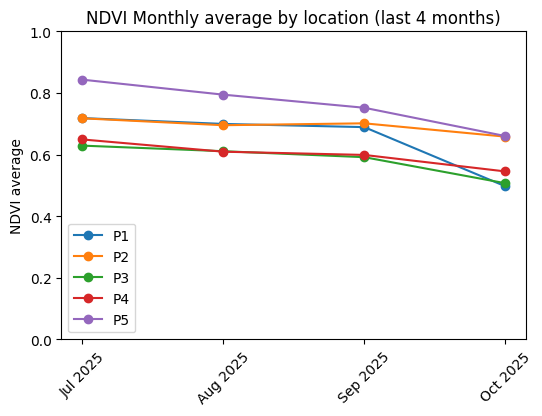

In [9]:

import folium
import math
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from folium.elements import MacroElement
from jinja2 import Template
import datetime
import calendar



# Define points with names and icon URLs
# ---------------------------
points = [
    {
        'name': 'P1',
        'coords': ee.Geometry.Point([-71.589217,-34.565775]),
        'png': 'https://i.ibb.co/0Y77DNQ/close.png',
        'gif': 'https://i.ibb.co/YcCRFvf/open.gif'
    },
    {
        'name': 'P2',
        'coords': ee.Geometry.Point([-71.586606,-34.566151]),
        'png': 'https://i.ibb.co/0Y77DNQ/close.png',
        'gif': 'https://i.ibb.co/YcCRFvf/open.gif'
    },
    {
        'name': 'P3',
        'coords': ee.Geometry.Point([-71.587953,-34.565243]),
        'png': 'https://i.ibb.co/0Y77DNQ/close.png',
        'gif': 'https://i.ibb.co/YcCRFvf/open.gif'
    },
    {
        'name': 'P4',
        'coords': ee.Geometry.Point([-71.588206,-34.567478]),
        'png': 'https://i.ibb.co/0Y77DNQ/close.png',
        'gif': 'https://i.ibb.co/YcCRFvf/open.gif'
    },
    {
        'name': 'P5',
        'coords': ee.Geometry.Point([-71.584892,-34.567068]),
        'png': 'https://i.ibb.co/0Y77DNQ/close.png',
        'gif': 'https://i.ibb.co/YcCRFvf/open.gif'
    }
]

# ---------------------------
# Sentinel-2 Collection & NDVI
# ---------------------------
collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2023-05-01', '2023-05-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

ndvi_collection = collection.map(calculate_ndvi)

def get_ndvi_at_point(point):
    ndvi_mean = ndvi_collection.select('NDVI').median().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=10
    )
    try:
        value = ndvi_mean.getInfo().get('NDVI', None)
    except Exception as e:
        print(f"Error fetching NDVI: {e}")
        value = None
    return value

# ---------------------------
# Create Base Map
# ---------------------------
map_center = points[4]['coords'].coordinates().getInfo()
Map = folium.Map(location=[map_center[1], map_center[0]], zoom_start=17)

folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI',
    name='ESRI Satellite',
    max_zoom=22
).add_to(Map)

# ---------------------------
# Add Title Box
# ---------------------------
title_box_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    top: 10px;
    right: 28px;
    width: 230px;
    background-color: white;
    border: 2px solid black;
    border-radius: 8px;
    padding: 12px;
    font-family: Arial, sans-serif;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.2);
    z-index: 10000;
">
    <h3 style="margin: 0 0 8px 0; color: black; font-size: 16px; text-align: center;">NDVI Monthly Monitoring</h3>
    <p style="margin: 4px 0; color: black; font-size: 12px; text-align: center;">Specie:Quillay</p>
    <p style="margin: 4px 0 0 0; color: black; font-size: 12px; text-align: center;">Chile-South-America</p>
</div>
{% endmacro %}
"""

class FixedTitleBox(MacroElement):
    def __init__(self):
        super().__init__()
        self._template = Template(title_box_html)

Map.get_root().add_child(FixedTitleBox())

# ---------------------------


# ---------------------------
# NDVI Monthly Average per Point (Dynamic N Months Back)
# ---------------------------
import datetime
import calendar

def monthly_ndvi_per_point(year, month, points):
    """Devuelve un diccionario con NDVI promedio de cada punto en un mes específico"""
    start_date = f"{year}-{month:02d}-01"
    last_day = calendar.monthrange(year, month)[1]  # último día del mes
    end_date = f"{year}-{month:02d}-{last_day:02d}"

    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(calculate_ndvi)

    ndvi_values = {}
    for point in points:
        ndvi_mean = collection.select('NDVI').median().reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point['coords'],
            scale=10
        ).getInfo()
        ndvi_values[point['name']] = ndvi_mean.get('NDVI', None)

    return ndvi_values


# Número de meses hacia atrás que quieres mostrar
N_MONTHS_BACK = 4   # <--- cambia este valor según lo necesites

today = datetime.date.today()
months_to_check = []

for i in range(1, N_MONTHS_BACK+1):  # desde 1 hasta N meses atrás
    target_month = today.month - i
    target_year = today.year
    if target_month <= 0:
        target_month += 12
        target_year -= 1
    months_to_check.append((target_year, target_month))

# Obtener valores NDVI para cada punto en esos meses
ndvi_time_series = {}
for (y, m) in months_to_check[::-1]:  # invertimos para orden cronológico
    month_label = f"{datetime.date(y, m, 1):%b %Y}"
    ndvi_time_series[month_label] = monthly_ndvi_per_point(y, m, points)


# ---------------------------
# Plot Line Chart
# ---------------------------
plt.figure(figsize=(6,4))

# Una línea por cada punto
for point in points:
    name = point['name']
    values = [ndvi_time_series[m].get(name, None) for m in ndvi_time_series.keys()]
    plt.plot(list(ndvi_time_series.keys()), values, marker='o', label=name)

plt.ylabel("NDVI average")
plt.title(f"NDVI Monthly average by location (last {N_MONTHS_BACK} months)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()

# Convertir gráfico a imagen embebida
buf = BytesIO()
plt.savefig(buf, format="png", bbox_inches="tight")
plt.close()
data = base64.b64encode(buf.getbuffer()).decode("ascii")
img_html = f'<img src="data:image/png;base64,{data}" style="width:300px;height:auto;">'

chart_box_html = f"""
{{% macro html(this, kwargs) %}}
<div style="
    position: fixed;
    bottom: 400px;
    right: 20px;
    width: 320px;
    background-color: white;
    border: 2px solid black;
    border-radius: 8px;
    padding: 10px;
    font-family: Arial, sans-serif;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.2);
    z-index: 10000;
">
    <h4 style="margin: 0 0 6px 0; text-align: center;">NDVI last {N_MONTHS_BACK} Months</h4>
    {img_html}
</div>
{{% endmacro %}}
"""

class ChartBox(MacroElement):
    def __init__(self):
        super().__init__()
        self._template = Template(chart_box_html)

Map.get_root().add_child(ChartBox())





# ---------------------------
# Add Markers + Callout Labels with NDVI Values
# ---------------------------
for point in points:
    ndvi_value = get_ndvi_at_point(point['coords'])
    coords = point['coords'].coordinates().getInfo()  # [lon, lat]
    lat, lon = coords[1], coords[0]

    png_url = point['png'].strip()
    gif_url = point['gif'].strip()

    if ndvi_value is not None and isinstance(ndvi_value, (int, float)):
        ndvi_display = f"{ndvi_value:.2f}"
        if ndvi_value > 0.52:
            icon_url = gif_url
            popup_html = f'<strong>Point {point["name"]}</strong><br>NDVI: {ndvi_display}<br><img src="{gif_url}" width="150" height="150">'
        else:
            icon_url = png_url
            popup_html = f'<strong>Point {point["name"]}</strong><br>NDVI: {ndvi_display}<br><img src="{png_url}" width="150" height="150">'
    else:
        ndvi_display = "N/A"
        icon_url = png_url
        popup_html = f'<strong>Point {point["name"]}</strong><br>NDVI: Not Available'

    icon = folium.CustomIcon(icon_image=icon_url, icon_size=(60, 60))

    folium.Marker(
        location=[lat, lon],
        icon=icon,
        popup=folium.Popup(popup_html, max_width=100)
    ).add_to(Map)

    if ndvi_value is not None and ndvi_value > 0.52:
        text_color = "#228B22"
        bg_color = "#E6F4E6"
        tail_side = "left"
        border_side = "left"
    elif ndvi_value is not None:
        text_color = "#FF4500"
        bg_color = "#FFF0E6"
        tail_side = "left"
        border_side = "left"
    else:
        text_color = "#555"
        bg_color = "#F0F0F0"
        tail_side = "left"
        border_side = "left"

    callout_html = f'''
<div style="
    position: relative;
    font-family: Arial, sans-serif;
    font-size: 10px;
    font-weight: bold;
    color: {text_color};
    background-color: {bg_color};
    padding: 6px 10px;
    border-radius: 6px;
    white-space: nowrap;
    box-shadow: 1px 1px 3px rgba(0,0,0,0.3);
    min-width: 130px;
    text-align: center;
">
    {point["name"]} = NDVI Value {ndvi_display}
    <div style="
        position: absolute;
        {tail_side}: 100%;
        top: 50%;
        margin-{tail_side}: -10px;
        width: 0;
        height: 0;
        border-top: 6px solid transparent;
        border-bottom: 6px solid transparent;
        border-{border_side}: 6px solid {bg_color};
        transform: translateY(-50%);
    "></div>
</div>
'''


    offsetX, offsetY = 30, 30
    lat_offset = offsetY / 111111
    lon_offset = offsetX / (111111 * math.cos(math.radians(lat)))
    callout_location = [lat + lat_offset, lon + lon_offset]

    folium.Marker(
        location=callout_location,
        icon=folium.DivIcon(html=callout_html),
        zIndexOffset=1000
    ).add_to(Map)

# ---------------------------
# Save and Display
# ---------------------------
Map.save('quillay_ndvi_map_callouts.html')
Map